In [4]:
import asset_func as af
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit import QuantumCircuit, transpile
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error, phase_damping_error,amplitude_damping_error )

Set seed:

In [5]:
seed = 1

The observable:

In [6]:
obs = QuantumCircuit(5)
obs.x(range(5))
#obs.draw(style = "default")

## Native: $\text{CX, RZ, ID, SX, X}$

Transpiling the `cswap()` gate into the above basis gates:

In [7]:
cswap_qc = QuantumCircuit(3, name = 'cswap_t')
cswap_qc.cswap(0,1,2)

cswap_t = transpile(cswap_qc, basis_gates = ['cx', 'rz', 'id', 'sx', 'x'], optimization_level = 3, seed_transpiler = seed)

#cswap_t.draw() # uncomment to draw

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Redefining the `h()` gate into the above basis gates:

In [8]:
h_t_qc = QuantumCircuit(1, name = 'h_t')
h_t_qc.rz(np.pi/2, 0)
h_t_qc.sx(0)
h_t_qc.rz(np.pi/2, 0)

h_t = h_t_qc.to_instruction()

Redefining the `GHZ()`, `derangement()` and `circ_assembler()` functions to use the `cswap_t()` gates:

In [9]:
def GHZ_t(qc):

    registers = qc.qregs[:0:-1]
    numQubits = registers[0].size

    for reg in registers:
        qc.append(h_t, [reg[0]])

        for qubit in range(numQubits-1):
            qc.cnot(reg[qubit], reg[qubit+1])

In [10]:
af.GHZ = GHZ_t

In [11]:
def derangement_t(qc):
    
    ancilla_qubit = qc.ancillas[0]
    registers = qc.qregs[1:]
    numQubits = registers[0].size

    for i in reversed(range(1, len(registers))):
        for j in reversed(range(numQubits)):
            qc.append(cswap_t,(ancilla_qubit, registers[i][j], registers[i-1][j]))


In [12]:
af.derangement = derangement_t

In [13]:
def circ_assembler_t(numReg, numQ, numAnc, sigma, basis_gates, seed = 1, der_op = True):

    qc = af.iniQC(numReg, numQ, numAnc)
    af.GHZ(qc)
    qc.barrier()
    qc.append(h_t, [0])
    if der_op == True:
        af.derangement(qc)
        qc.barrier()
    if sigma != False: 
        qc = af.observable(sigma = sigma, qc = qc, basis_gates = basis_gates, seed = seed)
    qc.append(h_t, [0])

    return(qc)


In [14]:
af.circ_assembler = circ_assembler_t

### Exploring depolarizing noise:

In [15]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit = [] # empty list for mitigated expectation values
unmit = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = depolarizing_error(0.2*error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit.append(mit_exp)
    unmit.append(unmit_exp)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


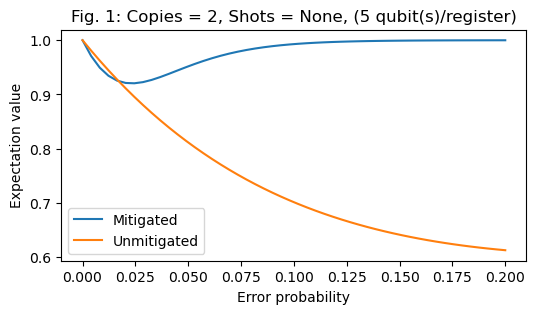

In [16]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(err_range, mit, label = 'Mitigated')
ax.plot(err_range, unmit, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 1: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)

plt.show()

Interesting behaviour for the mitigated case, lets explore!

First we look at the 4 expectation values for the circuits: 
- the mitigated circuit with observable
- the mitigated circuit without the observable
- the unmitigated circuit with the observable
- the unmitigated circuit without the observable

In [17]:
mit_full_circ = af.circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs,
                                basis_gates = basis_gates, seed = 1, der_op = True).decompose(['cswap_t', 'h_t'])

mit_no_obs_circ = af.circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = False,
                                basis_gates = basis_gates, seed = 1, der_op = True).decompose(['cswap_t', 'h_t'])

unmit_full_circ = af.circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs,
                                basis_gates = basis_gates, seed = 1, der_op = False).decompose(['cswap_t', 'h_t'])

unmit_no_obs_circ = af.circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = False,
                                basis_gates = basis_gates, seed = 1, der_op = False).decompose(['cswap_t', 'h_t'])

In [18]:
mit_full = []
mit_no_obs = []
unmit_full = []
unmit_no_obs = []

err_range = np.linspace(0,0.2,50)

for i in tqdm(err_range):
    error = i

    err_1q = depolarizing_error(0.2*error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    prob_mit_no_obs = af.prob0(qc = mit_no_obs_circ, nb_shots = None, noise_model = noise_m)
    mit_no_obs.append(prob_mit_no_obs)

    prob_mit_full = af.prob0(qc = mit_full_circ, nb_shots = None, noise_model = noise_m)
    mit_full.append(prob_mit_full)

    prob_unmit_no_obs= af.prob0(qc = unmit_no_obs_circ, nb_shots = None, noise_model = noise_m)
    unmit_no_obs.append(prob_unmit_no_obs)

    prob_unmit_full= af.prob0(qc = unmit_full_circ, nb_shots = None, noise_model = noise_m)
    unmit_full.append(prob_unmit_full)


100%|██████████| 50/50 [02:07<00:00,  2.55s/it]


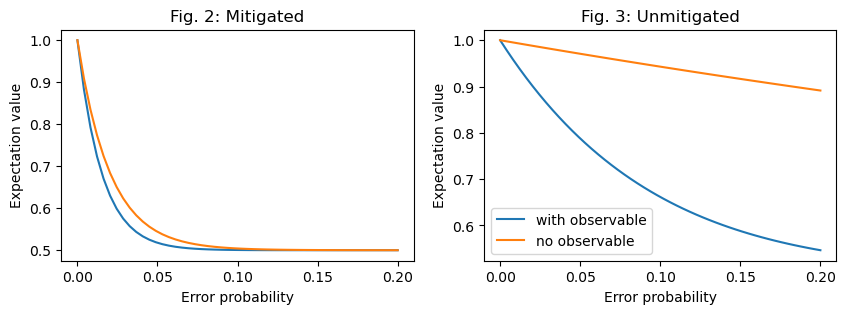

In [19]:

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 3))
#ax.plot(np.linspace(0,0.5,50), probs_id, label = 'mitigated ID')
ax1.plot(err_range, mit_full, label = 'with observable')
ax1.plot(err_range, mit_no_obs, label = 'no observable')
ax1.set(
        title = 'Fig. 2: Mitigated',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )


ax2.plot(err_range, unmit_full, label = 'with observable')
ax2.plot(err_range, unmit_no_obs, label = 'no observable')
ax2.set(
        title = 'Fig. 3: Unmitigated',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax2.legend()

plt.show()

Next we look at how we calculate the final probability $\text{prob}_0$ in the `exp_value` function that is passed to the `circ_tester` function:

As we are assuming no knowladge of the dominant eigenvector's eigenvalue we are using $\text{Method A}$ from the [paper](https://arxiv.org/abs/2011.05942):

$$
\text{Method A:} \qquad \frac{2\text{prob}_0 - 1}{2\text{prob'}_0 - 1} = \textcolor{orange}{\frac{\text{Tr}[\rho^n \sigma]}{\text{Tr}[\rho^n ]}} =  \langle \psi |\sigma| \psi \rangle + \varepsilon_A
$$

We can see that in order to get the expectation value of the ancilla qubit, we divide $\text{Tr}[\rho^n \sigma]$ (*with observable*) with $\text{Tr}[\rho^n ]$ (*no observable*). 

From this we can explain the behaviour of the mitigated (and also the unmitigated) circuit in *Fig. 1*:
- Due to the noise from the `derangement` operator even without the observable the expectation value will tend to $0.5$ (i.e. totally random outcomes) as we increase the noise.
- After a high enough noise (just below $0.025$) the two circuits "catch up" both giving an expectation value of $0.5$. 
- This results in a "final" expectation value of $1$ for $\text{Method A}$.

>Note:
>It is simply a coincidence that the known and the 'final' noisy expectation value are both one. The ESD technique does not start to magically work better after a certain error treshold. 

- Looking at the unmitigated case, the circuit with the observable acts in a similiar fashion as in the mitigated case. Since the derangement operator is absent for the unmitigated case, less noise is introduced leading to a gentler gradient. This is even more pronounced for the unmitigated circuit with no observable, where we only have 2 hadamard gates (that gives 6 gates when decomposed) and hence even less noise leading to a linear gradient.



#### Depolarizing noise - shot based simulations

Now that we understand the reason behind our results we can also compare the exact simulations with the shot based ones. Here we look at 1000 and 10000 shots:

In [20]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 1000 # we are interested in estimated expectation value using 1000 shots

mit1k = [] # empty list for mitigated expectation values
unmit1k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = depolarizing_error(0.2*error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit1k.append(mit_exp)
    unmit1k.append(unmit_exp)

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


In [21]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 10000 # we are interested in estimated expectation value using 10000 shots

mit10k = [] # empty list for mitigated expectation values
unmit10k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = depolarizing_error(0.2*error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit10k.append(mit_exp)
    unmit10k.append(unmit_exp)

100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


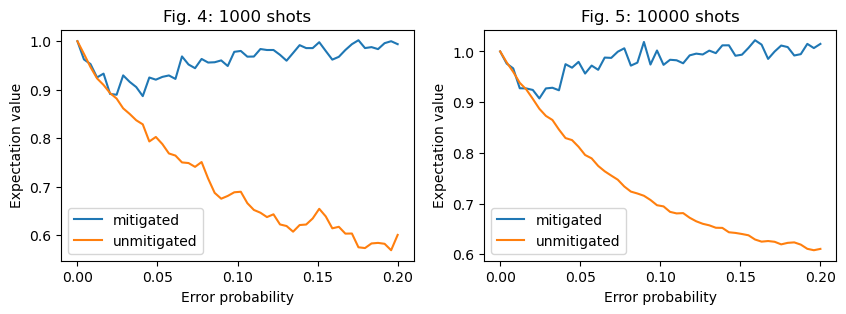

In [22]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 3))

ax1.plot(err_range, mit1k, label = 'mitigated')
ax1.plot(err_range, unmit1k, label = 'unmitigated')
ax1.set(
        title = 'Fig. 4: 1000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax1.legend()

ax2.plot(err_range, mit10k, label = 'mitigated')
ax2.plot(err_range, unmit10k, label = 'unmitigated')
ax2.set(
        title = 'Fig. 5: 10000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax2.legend()

plt.show()

Indeed we can see the same behaviour, but with a higher variance.

### Exploring amplitude damping noise:

Exact simulation:

In [23]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit_amp = [] # empty list for mitigated expectation values
unmit_amp = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = amplitude_damping_error(0.2*error, 1)
    err_2q = amplitude_damping_error(error, 1).tensor(amplitude_damping_error(error, 1))

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_amp.append(mit_exp)
    unmit_amp.append(unmit_exp)


100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


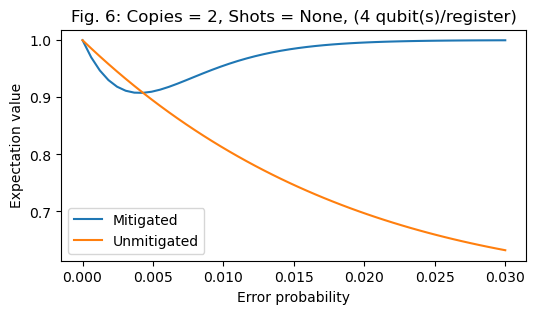

In [68]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(err_range, mit_amp, label = 'Mitigated')
ax.plot(err_range, unmit_amp, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 6: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)

plt.show()

#### Amplitude damping noise - shot based simulations

Now that we understand the reason behind our results we can also compare the exact simulations with the shot based ones. Here we look at 1000 and 10000 shots:

In [25]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 1000 

mit_amp1k = [] # empty list for mitigated expectation values
unmit_amp1k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = amplitude_damping_error(0.2*error, 1)
    err_2q = amplitude_damping_error(error, 1).tensor(amplitude_damping_error(error, 1))

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_amp1k.append(mit_exp)
    unmit_amp1k.append(unmit_exp)

100%|██████████| 50/50 [04:15<00:00,  5.10s/it]


In [26]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 10000 

mit_amp10k = [] # empty list for mitigated expectation values
unmit_amp10k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = amplitude_damping_error(0.2*error, 1)
    err_2q = amplitude_damping_error(error, 1).tensor(amplitude_damping_error(error, 1))

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_amp10k.append(mit_exp)
    unmit_amp10k.append(unmit_exp)

100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


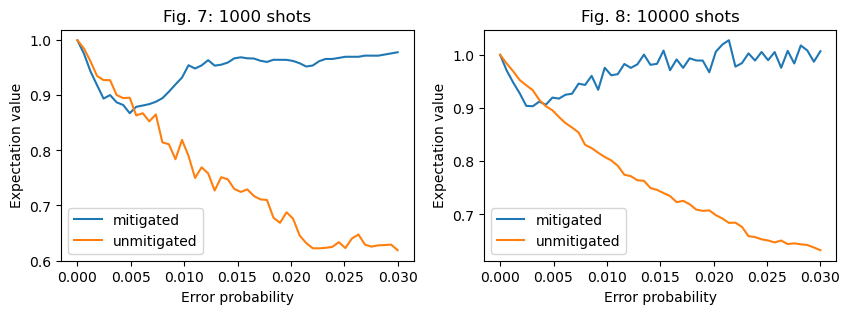

In [69]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 3))

ax1.plot(err_range, mit_amp1k, label = 'mitigated')
ax1.plot(err_range, unmit_amp1k, label = 'unmitigated')
ax1.set(
        title = 'Fig. 7: 1000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax1.legend()

ax2.plot(err_range, mit_amp10k, label = 'mitigated')
ax2.plot(err_range, unmit_amp10k, label = 'unmitigated')
ax2.set(
        title = 'Fig. 8: 10000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax2.legend()

plt.show()

### Exploring phase damping noise:

Exact simulation:

In [28]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit_damp = [] # empty list for mitigated expectation values
unmit_damp = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = phase_damping_error(0.2*error, 1)
    err_2q = phase_damping_error(error, 1).tensor(phase_damping_error(error, 1))

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_damp.append(mit_exp)
    unmit_damp.append(unmit_exp)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


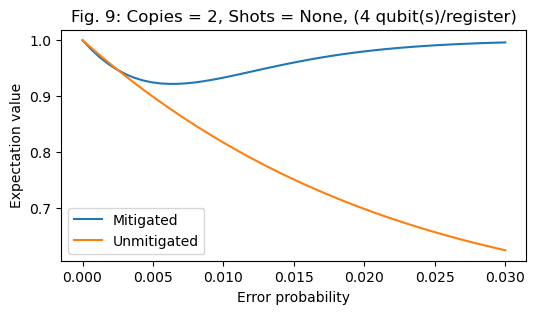

In [70]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(err_range, mit_damp, label = 'Mitigated')
ax.plot(err_range, unmit_damp, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 9: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)

plt.show()

In [30]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 1000 

mit_damp1k = [] # empty list for mitigated expectation values
unmit_damp1k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = phase_damping_error(0.2*error, 1)
    err_2q = phase_damping_error(error, 1).tensor(phase_damping_error(error, 1))

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_damp1k.append(mit_exp)
    unmit_damp1k.append(unmit_exp)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:10<00:00,  5.01s/it]


In [31]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 10000 

mit_damp10k = [] # empty list for mitigated expectation values
unmit_damp10k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = phase_damping_error(0.2*error, 1)
    err_2q = phase_damping_error(error, 1).tensor(phase_damping_error(error, 1))

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_damp10k.append(mit_exp)
    unmit_damp10k.append(unmit_exp)

100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


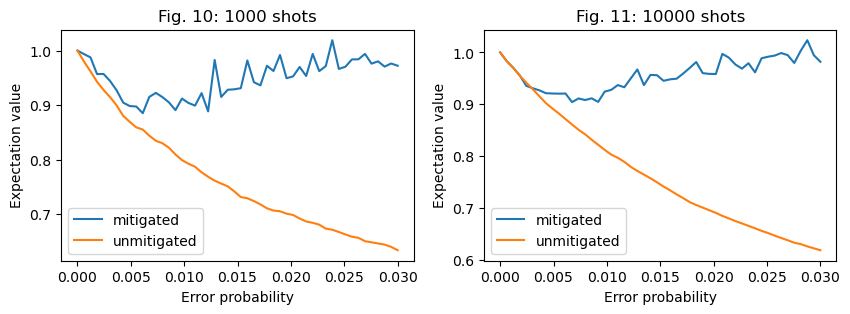

In [71]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 3))

ax1.plot(err_range, mit_damp1k, label = 'mitigated')
ax1.plot(err_range, unmit_damp1k, label = 'unmitigated')
ax1.set(
        title = 'Fig. 10: 1000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax1.legend()

ax2.plot(err_range, mit_damp10k, label = 'mitigated')
ax2.plot(err_range, unmit_damp10k, label = 'unmitigated')
ax2.set(
        title = 'Fig. 11: 10000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax2.legend()

plt.show()

### Noise model of *"3. Ground-state simulation Fig. 4"* from the [paper](https://arxiv.org/abs/2011.05942) :

- Single qubits gates:
    - dephasing with probability $\epsilon$
    - damping with probability $0.1 \epsilon$
    - depolarising with probability $0.07 \epsilon$

- 2 qubit gates:
    - same errors with $\epsilon \to 5\epsilon$

In [33]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit_costum = [] # empty list for mitigated expectation values
unmit_costum = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.03,50)

for error in tqdm(err_range):
    
    err_1phase = phase_damping_error(error, 1)
    err_1damp = amplitude_damping_error(0.1*error, 1)
    err_1depol = depolarizing_error(0.07*error, 1)

    err_2phase = phase_damping_error(5*error, 1).tensor(phase_damping_error(5*error, 1))
    err_2damp = amplitude_damping_error(5*0.1*error, 1).tensor(amplitude_damping_error(5*0.1*error, 1))
    err_2depol = depolarizing_error(5*0.07*error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1phase, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1damp, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1depol, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2phase, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2damp, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2depol, ['cx'], warnings=False)

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_costum.append(mit_exp)
    unmit_costum.append(unmit_exp)

100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


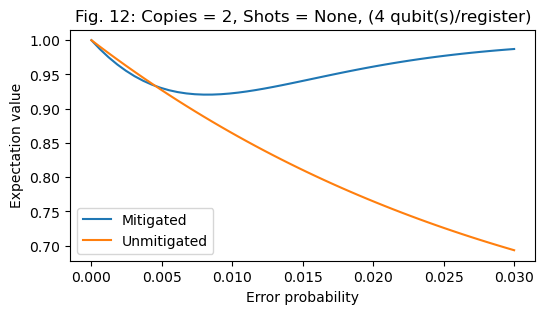

In [72]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(err_range, mit_costum, label = 'Mitigated')
ax.plot(err_range, unmit_costum, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 12: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)

plt.show()

In [45]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 4 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 1000 

mit_costum1k = [] # empty list for mitigated expectation values
unmit_costum1k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.03,50)

for error in tqdm(err_range):
    
    err_1phase = phase_damping_error(error, 1)
    err_1damp = amplitude_damping_error(0.1*error, 1)
    err_1depol = depolarizing_error(0.07*error, 1)

    err_2phase = phase_damping_error(5*error, 1).tensor(phase_damping_error(5*error, 1))
    err_2damp = amplitude_damping_error(5*0.1*error, 1).tensor(amplitude_damping_error(5*0.1*error, 1))
    err_2depol = depolarizing_error(5*0.07*error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1phase, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1damp, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1depol, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2phase, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2damp, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2depol, ['cx'], warnings=False)

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_costum1k.append(mit_exp)
    unmit_costum1k.append(unmit_exp)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
 18%|█▊        | 9/50 [00:40<03:21,  4.92s/it]

: 

: 

Hmm, let's try with only 4 copies.

In [65]:
obs_4 = QuantumCircuit(4)
for i in range(15):
    obs_4.x(range(4))
#obs_4.draw(style = "default")

In [66]:
copies = 2 # we create two copies 
qubits = 4 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs_4 # we are using the 'cnots' observable
basis_gates = ['cx', 'u'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit_costum = [] # empty list for mitigated expectation values
unmit_costum = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.03,50)

for error in tqdm(err_range):
    
    err_1phase = phase_damping_error(error, 1)
    err_1damp = amplitude_damping_error(0.1*error, 1)
    err_1depol = depolarizing_error(0.07*error, 1)

    err_2phase = phase_damping_error(5*error, 1).tensor(phase_damping_error(5*error, 1))
    err_2damp = amplitude_damping_error(5*0.1*error, 1).tensor(amplitude_damping_error(5*0.1*error, 1))
    err_2depol = depolarizing_error(5*0.07*error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1phase, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1damp, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1depol, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2phase, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2damp, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2depol, ['cx'], warnings=False)

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs_4, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_costum.append(mit_exp)
    unmit_costum.append(unmit_exp)

100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


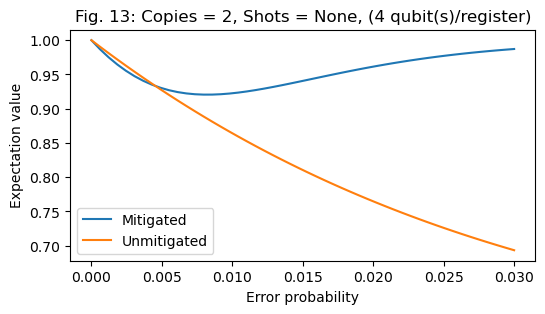

In [73]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(err_range, mit_costum, label = 'Mitigated')
ax.plot(err_range, unmit_costum, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 13: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)

plt.show()

In [38]:
copies = 2 # we create two copies 
qubits = 4 # each copy consists of 4 qubits (and 1 ancilla qubit)
sigma = obs_4 # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 1000 

mit_costum1k = [] # empty list for mitigated expectation values
unmit_costum1k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.03,50)

for error in tqdm(err_range):
    
    err_1phase = phase_damping_error(error, 1)
    err_1damp = amplitude_damping_error(0.1*error, 1)
    err_1depol = depolarizing_error(0.07*error, 1)

    err_2phase = phase_damping_error(5*error, 1).tensor(phase_damping_error(5*error, 1))
    err_2damp = amplitude_damping_error(5*0.1*error, 1).tensor(amplitude_damping_error(5*0.1*error, 1))
    err_2depol = depolarizing_error(5*0.07*error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1phase, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1damp, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1depol, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2phase, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2damp, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2depol, ['cx'], warnings=False)

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs_4, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_costum1k.append(mit_exp)
    unmit_costum1k.append(unmit_exp)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|██████████| 50/50 [00:09<00:00,  5.35it/s]


In [39]:
copies = 2 # we create two copies 
qubits = 4 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs_4 # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 10000

mit_costum10k = [] # empty list for mitigated expectation values
unmit_costum10k = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.03,50)

for error in tqdm(err_range):
    
    err_1phase = phase_damping_error(error, 1)
    err_1damp = amplitude_damping_error(0.1*error, 1)
    err_1depol = depolarizing_error(0.07*error, 1)

    err_2phase = phase_damping_error(5*error, 1).tensor(phase_damping_error(5*error, 1))
    err_2damp = amplitude_damping_error(5*0.1*error, 1).tensor(amplitude_damping_error(5*0.1*error, 1))
    err_2depol = depolarizing_error(5*0.07*error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1phase, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1damp, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_1depol, ['rz', 'id', 'sx', 'x'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2phase, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2damp, ['cx'], warnings=False)
    noise_m.add_all_qubit_quantum_error(err_2depol, ['cx'], warnings=False)

    mit_exp, unmit_exp = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs_4, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit_costum10k.append(mit_exp)
    unmit_costum10k.append(unmit_exp)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


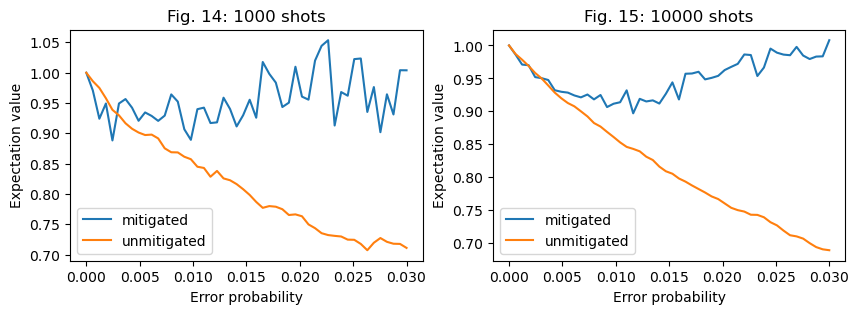

In [74]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 3))

ax1.plot(err_range, mit_costum1k, label = 'mitigated')
ax1.plot(err_range, unmit_costum1k, label = 'unmitigated')
ax1.set(
        title = 'Fig. 14: 1000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax1.legend()

ax2.plot(err_range, mit_costum10k, label = 'mitigated')
ax2.plot(err_range, unmit_costum10k, label = 'unmitigated')
ax2.set(
        title = 'Fig. 15: 10000 shots',
        xlabel = 'Error probability', 
        ylabel = 'Expectation value'
        )
ax2.legend()

plt.show()